Epoch 1/5 - Train Loss: 9.3153, Eval Loss: 1.8700, Eval Acc: 0.9168
Epoch 2/5 - Train Loss: 1.2674, Eval Loss: 0.9538, Eval Acc: 0.9098
Epoch 3/5 - Train Loss: 0.8355, Eval Loss: 0.6522, Eval Acc: 0.9430
Epoch 4/5 - Train Loss: 0.6412, Eval Loss: 0.5670, Eval Acc: 0.9449
Epoch 5/5 - Train Loss: 0.5685, Eval Loss: 0.4957, Eval Acc: 0.9461


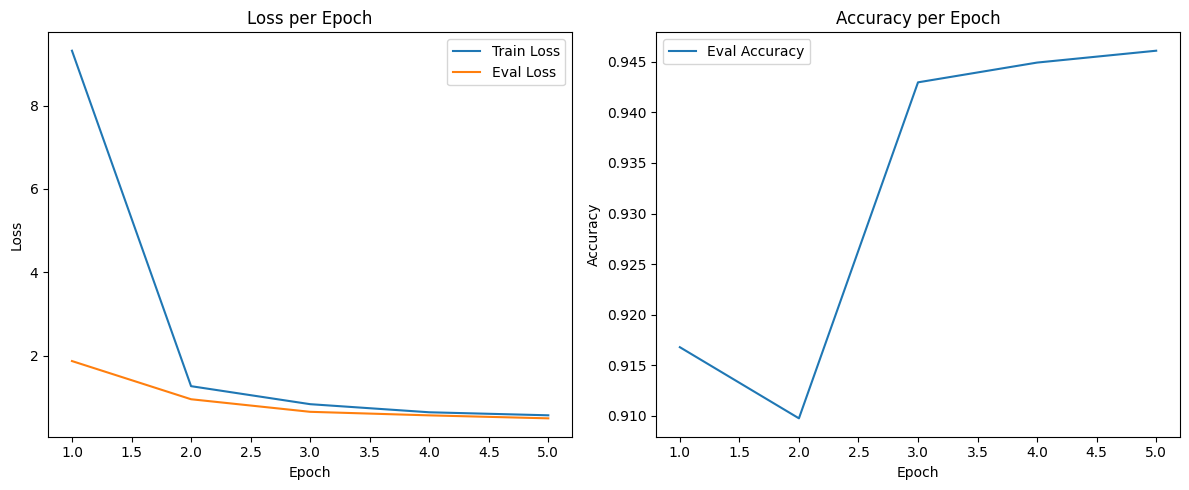

In [15]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Dataset sınıfı
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx],
                                  max_length=self.max_length,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors="pt")
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        # Masked Language Model için label olarak input_ids kullanacağız, -100 olmayanlar loss hesaplanacak
        labels = input_ids.clone()
        # Randomly mask tokens with 15% probability
        rand = torch.rand(input_ids.shape)
        mask_arr = (rand < 0.15) * (input_ids != tokenizer.cls_token_id) * (input_ids != tokenizer.sep_token_id) * (input_ids != tokenizer.pad_token_id)
        selection = torch.flatten(mask_arr.nonzero()).tolist()
        input_ids[selection] = tokenizer.mask_token_id

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Dosyaları oku
df1 = pd.read_csv("es_anlam_cumle.csv")
df2 = pd.read_csv("zit_anlam_cumle.csv")

texts = df1['Cumle'].tolist() + df2['Cumle'].tolist()

# Eğitim ve test ayrımı (%80 - %20)
split_idx = int(len(texts)*0.8)
train_texts = texts[:split_idx]
eval_texts = texts[split_idx:]

# Model ve tokenizer
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

train_dataset = TextDataset(train_texts, tokenizer)
eval_dataset = TextDataset(eval_texts, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)

num_epochs = 5
train_losses = []
eval_losses = []
eval_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Eval
    model.eval()
    total_eval_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            mask = labels != -100
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())

    avg_eval_loss = total_eval_loss / len(eval_loader)
    eval_losses.append(avg_eval_loss)
    accuracy = accuracy_score(all_labels, all_preds)
    eval_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}, Eval Acc: {accuracy:.4f}")

# Model kaydet
model.save_pretrained("./bert-turkish-mlm")
tokenizer.save_pretrained("./bert-turkish-mlm")

# Grafik çizimi
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), eval_losses, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), eval_accuracies, label="Eval Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy per Epoch")

plt.tight_layout()
plt.show()





